<img src="https://drive.google.com/uc?export=view&id=1dJqeveu_gE-UibcsRTJUPbigJ0hCjJ5D" width="100%">

# **Entendimiento del Negocio y Carga de Textos**
---

Este notebook es una plantilla que le puede servir como guía para el primer entregable del proyecto aplicado.

## **1. Marco de Proyecto**
---

Normalmente, se suele construir un marco de proyecto para mostrar los resultados del entendimiento del negocio, es decir, debemos dar respuesta a los siguientes elementos:

### **1.1. Trasfondo del Negocio**
---

- ¿Quién es el cliente o los beneficiarios del proyecto? ¿En qué dominio se encuentran (marketing, medicina, entre otros)?
- ¿Qué problemas del negocio o del dominio estamos tratando de solucionar?



*   El cliente es el area de recursos humanos o reclutamiento de fuerza laboral en la cual trabajo actualmente.
*   En las empresas grandes se complica el manejo de la busqueda y clasificación del personal, ya que estos envían en diferentes formatos sus curriculums, para lo cual se busca clasificar los skill del personal y cuando estos actualizan sus hojas de vida durante su tiempo en la empresa, esta no es actualizada o es muy dificil poder tener un seguimiento a través de una herramienta de empresa que filtre y clasifique tanto las actualizaciones de la hoja de vida como el ingreso de nuevo personal. Se quiere solucionar que al momento de ingresar o actualizar una hoja de vida no se tenga que llenar campo por campo, sino que exista un modelo que filtre y clasifique.



### **1.2. Alcance**
---

- ¿Qué  solución de procesamiento de lenguaje natural tratamos de implementar?
- ¿Qué  se hará?
- ¿De qué forma el cliente o beneficiario utilizará el producto del proyecto?



*   Tres soluciones de procesamiento de lenguaje natural, 1-> La extracción de los textos para antes de almacenarlos realizar un análisis gramatical indicando en una etiqueta HTML el texto a corregir y una posible corrección. 2-> La clasificación de los textos para elaborar diferenciación de experiencia y estudio. 3-> La automatización de búsqueda de perfiles mejorando el proceso y actualización y en una segunda etapa, haciendo scrapping desde los sitios publicos(ejemplo LinkedIn) para poder hacer la búsqueda de personal.
*   Primero poder tomar el documento con la hoja de vida y extraer el texto, realizando el filtrado y clasificación de los datos que contengan. Además de realizar correcciones de gramatica y retroalimentando los cambios que serían oportunos(similar a grammarly). También el poder evaluar y analizar el sentimiento de las personas en la escritura y descripción de su hoja de vida para realizar sugerencias.
*   En primera medida podrá utilizarlo para filtrar grandes cantidades de documentos de hoja de vida de los empleados que se almacenan en directorios, enviarlos a una base de datos NoSQL para mejorar su acceso pero filtrando antes las mejoras a realizar y si es posible sugerir cambios de gramatica, analizar el sentimiento especialmente de la descripción que realiza persona del curriculo y en futuro la idea es poder crear análisis especificos de similitudes, aptitudes, sentimientos, clasificación, etc.





### **1.3. Plan**
---

Puede agregar una lista de actividades con tiempos estimados, un diagrama de Gantt o integrar alguna herramienta de gestión de proyectos para mostrar la planeación del proyecto.

---
Luego de dos reuniones generadas en la empresa con el equipo encargado de la generación de la herramienta con la cual se realizará la administración de la información se definió el siguiente estimado de tiempo para la realización del proyecto.

*   SEMANA 1 -> EXTRACCIÓN DE TEXTOS: Se trabajó sobre la extracción de los textos desde los diferentes formatos de curriculos encontrados y su guardado en la base de datos NoSQL con la corrección de la gramatica en la descripción del perfil a través de un modelo preentrenado encontrado en huggingface.
*   SEMANA 2-3-4 -> CORPUS: Se trabajo en el corpus tratando de establecer la mejor forma para su preprocesamiento, ya que se encontraron hasta 22 tipos de curriculum en un directorio con solo 300.
*   SEMANA 3-4 -> EMBEDDINGS: Se trabajó en la extracción de caracteristicas necesarias por el área de recursos humanos para el filtrado del cual era la solicitud inicial. Para esto se trabajo tratando de emular estas carateristicas y organizandolas de un modo de metadata para su mejor funcionamiento.
*   SEMANA 4-5-6 -> MODELAMIENTO: Estamos trabajando en la busqueda del mejor modelo para poder clasificar y que el modelo realice la búsqueda de perfiles de una manera mas acertada. 
*   SEMANA 5-6 -> EVALUACIÓN: Estamos alterno al modelamiento evaluando el que mejor se comporta, pero este trabajo esta en desarrollo actualmente.

---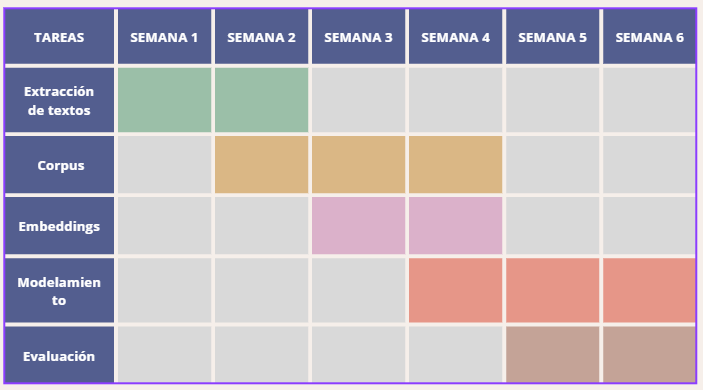



## **2. Definición del Corpus**
---

En esta sección debe adjuntar una descripción del corpus y agregar el código que permite su tratamiento.

### **2.1. Origen**
---

- ¿De dónde vienen los textos?
- ¿Se usa alguna herramienta o proceso para la descarga de la información textual?
- ¿Qué tipo de textos estamos manejando?




---


*   Los textos vienen de las curriculos que se encuentran en un directorio interno de la empresa, los cuales deben ser extraidos para almacenarlos en una base de datos de Mongo y poder hacer su procesamiento.
*   Se definió la siguiente arquitectura para la descarga. En primer lugar existirá un formulario que recibe el documento, este con una Azure Function preprocesa el texto cargando el respectivo modelo, luego envía a dos Azure Functions. La primera extrae la descripción del curriculo y revisa gramática, la segunda extrae el resto del texto y la ultima genera análisis de sentimiento 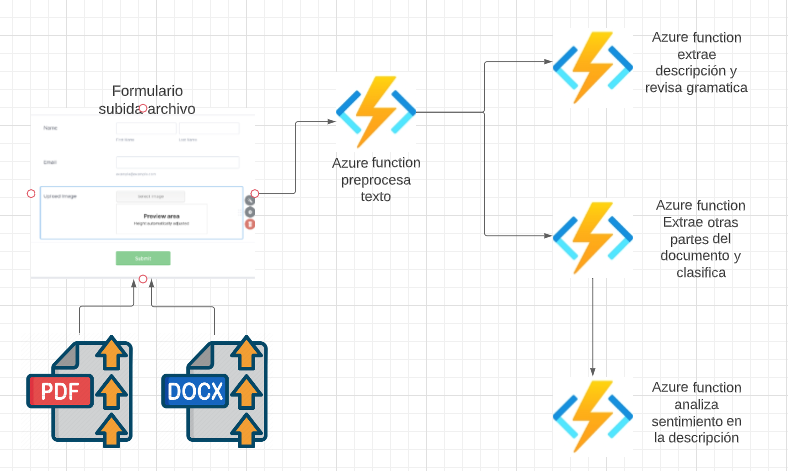
*   Todos los textos que se van a manejar estan en idioma ingles y son textos de lenguaje tecnologico.







### **2.2. Carga o Adquisición de Textos**
---

Agregue el código necesario en _Python_ para obtener o cargar el corpus.

In [1]:
# Instalamos la dependencia para convertir archivos docx a html
!pip install mammoth

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import mammoth
import bs4
from IPython.display import HTML
with open("/content/Profile_Developer.docx", "rb") as docx_file:
  result = mammoth.convert_to_html(docx_file)
  html = result.value
  messages = result.messages
soup = bs4.BeautifulSoup(html, 'html.parser')

In [3]:
# Adicionamos las funciones necesarias para normalizar, eliminar palabras y contar palabras
def get_text_normalize(soup, id):
  content = None
  tags_to_remove = ['em', 'strong'] 
  for tag in soup.findAll(tags_to_remove):
    tag.extract()
  content = [content.get_text().strip() for content in soup.findAll(id)]
  strip_text = " ".join(content)
  return strip_text.lower()

def delete_words(soup, id, min_len, max_len, stops):
    resulting_tokens = None
    text = get_text_normalize(soup, id)
    texts = text.split(" ")
    names = list(filter(lambda texts: len(texts) >= min_len and len(texts) <= max_len, texts))
    resulting_tokens = list(filter(lambda names: names not in stops, names))
    return " ".join(resulting_tokens)

def count_words(
        soup, id, min_len, max_len,
        stops, words
        ):
    counts = {}
    text = delete_words(soup, id, min_len, max_len, stops)
    for word in words:
      counts[word] = text.count(word)
    return counts

def print_counts(
        soup, id, min_len, max_len,
        stops, words
        ):
    values = []
    head = ["Palabra", "Conteo"]
    values.append(head)    
    values.append(["-","-"])
    counts = count_words(soup, id, min_len, max_len, stops, words)  
    for name, count in counts.items():
      values.append([name,count])
    val = ""
    for value in values:
      val += f"|"
      for j in value:
        val += f"{j:<20}|" if j != "-" else f"{j*20}|"
      val += f"\n"
    return val[:-1]

In [4]:
# Verificamos que la extracción funcione.
stops = ["he", "is", "a", "in", "as", "on"]
words = ["senior", "python"]
print(print_counts(soup, "p", 3, 10, stops, words))

|Palabra             |Conteo              |
|--------------------|--------------------|
|senior              |1                   |
|python              |13                  |


<img src="https://drive.google.com/uc?export=view&id=1_ivkJIHHhWZVQDzNPvpuXNBhWaDfnpd_" width="100%">

# Entendimiento y Preparación del Corpus
---

Este notebook es una plantilla que le puede servir como guía para el segundo entregable del proyecto aplicado.

## **1. Análisis Exploratorio de los Textos**
---

Normalmente en el análisis exploratorio de los textos, se trata de dar respuesta a los siguientes elementos:

### **1.1. Resumen General de los Textos**
---

- ¿Cuántos documentos tiene el corpus?
- ¿En qué idioma se encuentran?
- ¿Qué tamaño en MB tiene el corpus?
- ¿Hay alguna relación entre distintos documentos del corpus?

---
Realizamos reunión en la empresa con el Product Owner y el Technical Lead, en 
la cual se definió el proceso a seguir para la generación del proyecto en la 
empresa, que como se indicó en la primera entrega del proyecto aplicado es para 
realización de un modelo de machine learning que realice la extracción de texto,
su posterior analisis y respuesta que se guardará en una base de datos.
El insumo a usar son 22 tipos de formatos de hoja de vida y tres sitios web de los cuales mediante scrapping se realizará la extracción de su contenido.

*   Se tienen 6 documentos identificados en el corpus de los 22 tipos de documentos(valga la redundancia) y en los dos sitios web.
*   Todos se encuentran en Idioma Ingles pero en una segunda versión del modelo se pueda incluir otros idiomas.
*   Es relativo a la cantidad de experiencia de la persona que genera la hoja de vida y del diseño del documento, actualmente de los 22 formatos de hoja de vida encontramos divido en archivos con extensiones .pdf y .docx. También encontramos otra caracteristica y es el tipo de diseño, ya que algunos son exportaciones generadas por aplicaciones web como Canva con imagenes de mejor calidad pero que en peso puedan ser grandes no excediendo 10Mb por archivo. Vale resaltar que serían los archivos de 10000 empleados además de los que se quisiera contratar.
*   Ya en el analisis del corpus se tiene una relación en la información, ya que toda es la descripción de la persona y por ende hay información repetida que al momento de filtrarla para su almacenamiento en la base de datos debe ser analizada.



### **1.2. Resumen de la Calidad de los Textos**
---

- ¿Hay datos faltantes o documentos vacíos?
- ¿Existen documentos ilegibles o con problemas de codificación?
- ¿Hay mezcla de idiomas en el corpus?, ¿qué se puede hacer al respecto?



---



*   Si, dependiendo de la experiencia de la persona que realiza la hoja de vida, en unos perfiles se presentan datos faltantes y documentos vacios.
*   Hemos identificado muchos problemas de gramatica para las personas que no son nativas de paises con idioma ingles como predominante, por lo cual estos archivos contienen documentos ilegibles y que presentan problemas de codificación que el modelo debe poder filtrar y en lo posible sugerir que cambios deben hacerse.
*   No debería presentarse ya que por directriz de la empresa los archivos donde estan los documentos del corpus, en la primera fase deben ser en Ingles. Para una segunda fase si es posible la mezcla de idiomas y por lo cual deben adicionarse filtros que realicen esto al momento del analisis inicial.





### **1.3. Tipos de variables**
---

- ¿El corpus tiene una variable objetivo a estimar?, de ser así, ¿es una variable continúa o categórica?
- Analice la distribución de las etiquetas, identifique si hay desbalanceo de datos.
- Analice los documentos, y determine cuál es la distribución de la longitud de los documentos a nivel carácter o palabra.
- ¿El conjunto de datos cuenta con otras variables adicionales?, de ser así, debe analizar cuáles se incorporarán en el modelo y hacer un análisis descriptivo de las mismas.



---


*   El corpus va a tener varias variables objetivo a estimar y que se encuentran en definición del Product Owner con el personal de RRHH, en lo que se ha definido son variables categoricas.
*   Se encuentra al manejar diferentes tipos de archivos de donde se va a extraer la información que las etiquetas no son iguales y se encuentra un desbalanceo grande en los datos por la diferencia de los archivos.
*   De acuerdo a lo solicitado la distribución debe ser a nivel palabra.
*   Si se cuenta con variables adicionales como lo son los tipos de lenguajes de programación y los skills de las personas que envían el curriculo.





### **1.4. Relación Entre Variables**
---

- Analice si existe alguna relación entre las variables. Puede utilizar medidas de correlación o visualizaciones.
- Identifique si hay redundancia entre las variables para una posterior eliminación o selección.



---



Luego de reunión se encuentra relación entre los tipos de categoría filtrados de acuerdo al tipo de curriculo. Existen medidas de correlación entre estos y de acuerdo al análisis no se encuentra redundancia entre las variables.



## **2. Limpieza de los Textos**
---

La selección de las técnicas de preprocesamiento del corpus puede variar en cada conjunto de datos. Recuerde que puede aplicar (no necesariamente todas) las técnicas generales vistas en el curso, tales como:

- Tokenizacion
- Normalización de textos.
- Limpieza con expresiones regulares.
- Lematización.
- Filtrado de palabras.
- Modificaciones en la grafía.

<img src="https://drive.google.com/uc?export=view&id=1F-C6HoHw-N9fYGyRO-c_X2q9pV8jbPCE" width="100%">

# Extracción de Características
---

Este notebook es una plantilla que le puede servir como guía para el tercer entregable del proyecto aplicado.

## **1. Selección del Embedding**
---

Seleccione el tipo de **embedding** que considere más apropiado para su problema. Recuerde las siguientes consideraciones:

- **Bolsas de palabras**: son útiles para representar documentos completos. Funcionan bien con corpus pequeños (<10000 documentos).
- **TF-IDF**: permite obtener una representación ponderada de documentos completos; es una alternativa a las bolsas de palabras.
- **Bolsas de N-grams**: a nivel de carácter son útiles para representar palabras o segmentos cortos de texto, funcionan bien con corpus pequeños (<10000 documentos).
- **Word2Vec**: permite representar palabras de forma semántica, requiere corpus grandes para un buen resultado (>10000 documentos).
- **FastText**: permite representar palabras o segmentos cortos de texto, funcionan bien con corpus grandes (>10000 documentos). Es una alternativa a word2vec que puede representar palabras fuera del vocabulario.
- **Doc2Vec**: permite representar documentos completos de forma semántica. Funciona bien con corpus grandes (>10000 documentos).

Justifique la selección del embedding:



---

Para obtener el tipo de embedding se revisó y el más adecuado es el de TF-IDF ya que presenta mas precisión que el de bolsa de palabras.

## **2. Implementación del Embedding**
---

Implemente la estrategia de embedding a partir del conjunto de datos pre-procesado. Recuerde que:

- `sklearn`: permite implementar bolsas de palabras, TF-IDF y bolsas de N-grams a partir del módulo `sklearn.feature_extraction.text`.
- `gensim`: permite implementar word2vec, fasttext y doc2vec desde `gensim.models`.
- `spacy`: permite representar textos con embeddings pre-entrenados con el atributo `vector`.

## **3. Exploración del Embedding**
---

Puede explorar la representación obtenida por medio de distintas técnicas de visualización o métricas:

- **Análisis de Correlaciones**: si tiene una variable objetivo, puede evaluar correlaciones entre los embeddings y dicha variable.
- **Nubes de palabras**: puede utilizar gráficos de tipo `wordcloud` para visualizar representaciones basadas en conteos
- **Distribuciones**: puede calcular histogramas o gráficos de densidad para mostrar la distribución de embeddings semánticos.

<img src="https://drive.google.com/uc?export=view&id=1ulQviLAnsnBLrWSQs3vXuTUsAI0vloz-" width="100%">

# Modelamiento y Evaluación
---

Este notebook es una plantilla que le puede servir como guía para el cuarto entregable del proyecto aplicado.

## **1. Tipo de Modelamiento**
---

Seleccione el tipo de modelo que puede usar para dar respuesta al problema de NLP. Recuerde que dispone de modelos que incluyen:

- **Regresión**: se busca estimar un valor continúo a partir de los textos.
- **Clasificación**: permite estimar un valor categórico a partir de los textos.
- **Agrupamiento**: permite encontrar grupos de documentos similares.
- **Modelos de tópicos**: permite encontrar temas/tópicos dentro del corpus e interpretarlo.
- **Otros modelos**: recuerde que dispone de otros tipos de tareas supervisadas y no supervisadas desde NLP. Puede utilizar modelos pre-enternados con el fin de dar una solución.

Justifique la selección del modelo.



---


De acuerdo a las reuniones en la empresa con el equipo, escogimos para la solución propuesta el uso no de un modelo específico, sino que realice utilización de tres tipos de modelamiento. 


*   En primer lugar hacer clasificación sobre los diferentes skills que se obtendran de los profiles en el proceso obtención de textos hasta su caracterización
*   El segundo tipo se realizará Agrupamiento para la obtención de los profiles similares y poder establecer patrones usados en su creación
*   Y como ultimo el modelado de tópicos, para poder encontrar y establecer los diferentes topicos a usar.

Como lo indique en Campuswire, el acceso al repositorio en el cual se esta generando este análisis y donde se ha trabajado con la extracción de los textos desde archivos pdf, docx, xls y que tienen ligado una base de datos de MongoDB, no me lo habilitaron el día de hoy por cuestiones de mantenimiento y actualización, para poder hacer la exportación de la data para este analisis y el respectivo pipeline que estamos usando. 
Por lo que me vi forzado a realizarlo a partir de un archivo de kaggle que tiene similitud al que estamos opteniendo al momento de importar el summary del profile luego de la extracción del texto a través de una Azure function.

Por este motivo para esta entrega solo realizare el modelamiento utilizando la opción 2 haciendo un agrupamiento de documentos similares sobre el corpus.

## **2. Implementación del modelo**
---

A continuación encuentra los pasos que puede seguir para la implementación de un modelo:

In [5]:
!pip install unidecode Pillow matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### **2.1. Importar Modelo**
---

Seleccione la librería de NLP que utilizará para el modelo e impórtelo:

In [6]:
import re
import spacy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from unidecode import unidecode
from IPython.display import display
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
# Modelo a usar KMeans

/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


### **2.2. Entrenamiento del Modelo y Selección de Hiperparámetros**
---

Si está utilizando un modelo que requiere entrenamiento, deberá entrenarlo y seleccionar un conjunto de hiperparámetros válido para el mismo:

In [8]:
data = pd.read_csv('/content/UpdatedResumeDataSet.csv', delimiter=",")
data.head()


,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."


In [9]:
clean_data = data.dropna()
complete_corpus = list(clean_data['Resume'])
corpus = complete_corpus[::50]
nlp = spacy.blank("en")

In [10]:
def preprocess(text):
    doc = nlp(text) # creamos un documento de spacy
    no_stops = " ".join(
        token.text
        for token in filter(
            lambda token: not token.is_stop and len(token) > 3 and len(token) < 24,
            doc,
            )
        ) # eliminamos stopwords y palabras por longitud
    norm_text = unidecode(no_stops.lower()) # normalizamos el texto
    no_chars = re.sub(r"[^a-z ]", " ", norm_text) # eliminamos caracteres especiales
    no_spaces = re.sub(r"\s+", " ", no_chars) # eliminamos espacios duplicados
    return no_spaces.strip()

In [11]:
data = data.assign(
        resume = data.Resume.apply(preprocess)  
)      

In [12]:
display(data.head())

,Category,Resume,resume
0,Data Science,Skills * Programming Languages: Python (pandas...,skills programming languages python pandas num...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...,education details rgpv data scientist data sci...
2,Data Science,"Areas of Interest Deep Learning, Control Syste...",areas interest deep learning control system de...
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...,skills python hana tableau hana hana lumira li...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab...",education details ymcaust faridabad haryana da...


## **3. Evaluación o Aplicación del modelo**
---

Si entrenó un modelo, recuerde que debe reportar el desempeño del mismo sobre un conjunto de datos no visto (test). Considere que dispone de las siguientes métricas:

- **Clasificación**: accuracy, precision, recall, f1-score, AUC.
- **Regresión**: $r^2$, error cuadrático medio, error absoluto medio.
- **Agrupamiento**: coeficiente de silueta, índice de Davies-Bouldin.
- **Tópicos**: perplexity, score de coherencia.

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer(sublinear_tf=True, min_df=5).fit(data.resume)
features = vect.transform(data.resume).toarray()
display(features.shape)

(962, 4989)

In [14]:
from sklearn.decomposition import PCA
reductor = PCA(n_components=0.95).fit(features)
reduced_features = reductor.transform(features)
display(reduced_features.shape)

(962, 135)

Adicionalmente, si utilizó un modelo pre-entrenado, debe generar predicciones y mostrar el resultado final de la aplicación del modelo sobre sus datos:

In [15]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
k_range = np.arange(2, 11, 1)

In [16]:
best_score = -1 
metrics = [] 
for k in k_range:
    model = KMeans(n_clusters=k, random_state=0).fit(reduced_features) 
    score = silhouette_score(
        reduced_features,
        model.predict(reduced_features)
        ) 
    metrics.append(score)
    if score > best_score: 
        best_score = score 
        best_model = model 

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

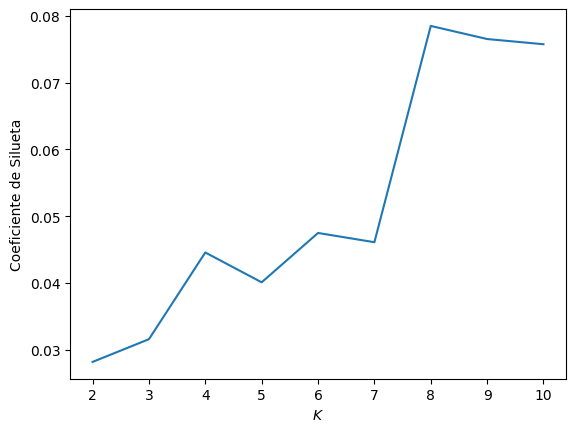

In [17]:
fig, ax = plt.subplots()
ax.plot(k_range, metrics)
ax.set_xlabel("$K$")
ax.set_ylabel("Coeficiente de Silueta")
ax.set_xticks(k_range)
fig.show()

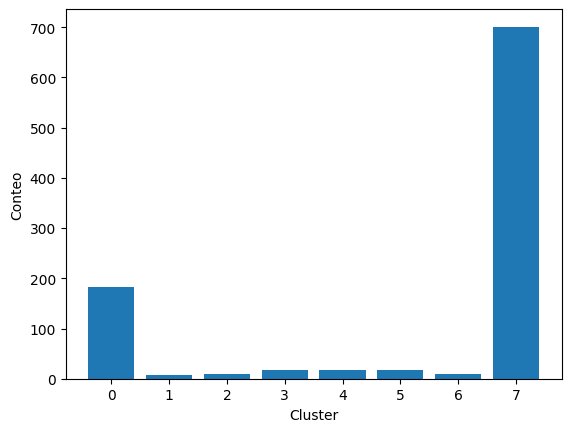

In [18]:
clusters = best_model.predict(reduced_features)
cats, counts = np.unique(clusters, return_counts=True)
fig, ax = plt.subplots()
ax.bar(cats, counts)
ax.set_xlabel("Cluster")
ax.set_ylabel("Conteo")
fig.show()

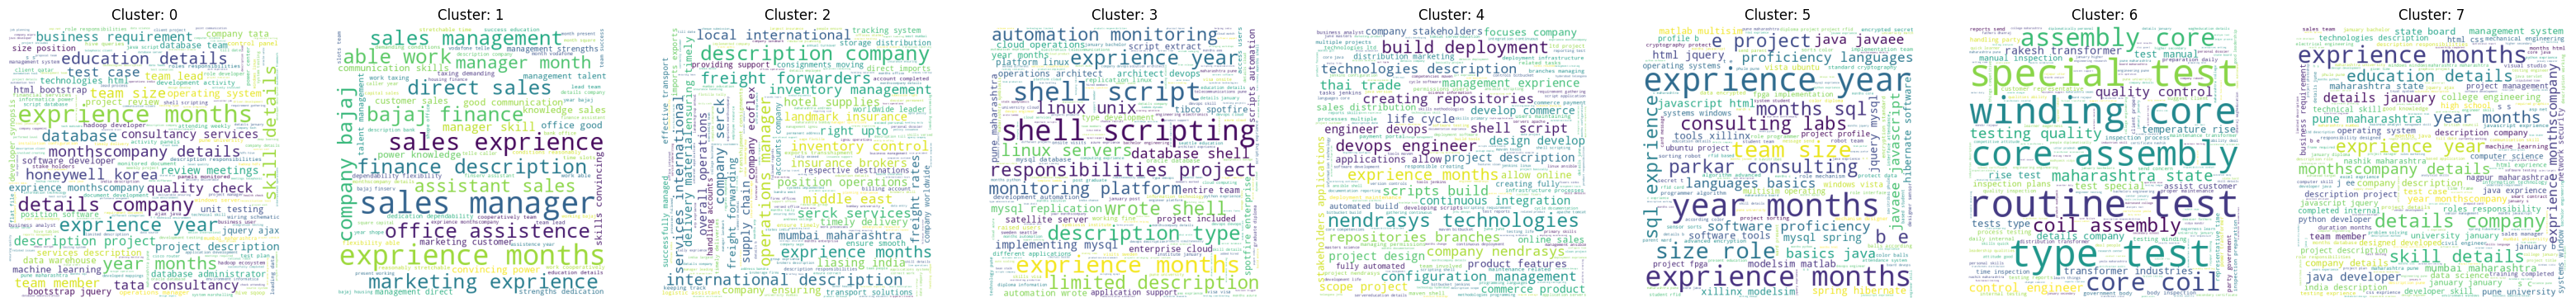

In [19]:
from wordcloud import WordCloud
predictions = pd.DataFrame({"text": data.resume, "cluster": clusters})
grouped_texts = (
        predictions
        .groupby("cluster")
        .agg({"text": lambda series: " ".join(series)})
        .reset_index()
        )
fig, axes = plt.subplots(
    1,
    best_model.n_clusters,
    figsize=(5 * best_model.n_clusters, 5),
    )
for cluster in range(best_model.n_clusters):
    ax = axes[cluster]
    ax.set_title(f"Cluster: {cluster}")
    text = grouped_texts.loc[grouped_texts.cluster == cluster, "text"].iloc[0]
    wc = WordCloud(
        background_color="#FFFFFF",
        width=500,
        height=500
        ).generate(text)
    ax.imshow(wc)
    ax.axis("off")
fig.show()

In [22]:
#Evaluacion
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

def vectorizer(corpus):
    vect = TfidfVectorizer(max_features=1000, 
                                 sublinear_tf=True).fit(corpus)
    features = vect.transform(corpus).toarray()
    return features, vect

def label_encode(labels):
    encoder = LabelEncoder().fit(labels)
    encoded_labels = encoder.transform(labels)
    return encoded_labels, encoder

def split_data(features, labels, test_size, seed): 
    features_train, features_test, labels_train, labels_test = train_test_split(
        features, labels,
        test_size=test_size,
        random_state=seed,
        stratify=labels,
    )
    return features_train, features_test, labels_train, labels_test

def random_forest(features_train, labels_train, max_depth, n_estimators, seed):
    model = RandomForestClassifier(max_depth=max_depth, random_state=seed,
                                   n_estimators=n_estimators
                                   ).fit(features_train, labels_train)
    return model

def evaluation(model, features_test, labels_test):
    predictions = model.predict(features_test)
    report = classification_report(labels_test, predictions)
    return report

In [26]:
features, vect = vectorizer(data.resume)
encoded_labels, encoder = label_encode(data.Category)
features_train, features_test, labels_train, labels_test = split_data(
        features, encoded_labels, test_size=0.3, seed=42
        )
model = random_forest(features_train, labels_train, 5, 50, 42)
report = evaluation(model, features_test, labels_test)
print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       1.00      1.00      1.00        11
           2       1.00      0.88      0.93         8
           3       1.00      1.00      1.00        12
           4       1.00      1.00      1.00         8
           5       1.00      0.43      0.60         7
           6       1.00      0.83      0.91        12
           7       1.00      1.00      1.00        10
           8       1.00      0.94      0.97        17
           9       1.00      0.38      0.55         8
          10       1.00      1.00      1.00        12
          11       1.00      0.89      0.94         9
          12       1.00      0.38      0.56        13
          13       1.00      1.00      1.00        13
          14       1.00      1.00      1.00         9
          15       0.76      1.00      0.86        25
          16       1.00      1.00      1.00        12
          17       1.00    

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## **Créditos**

* **Profesor:** [Felipe Restrepo Calle](https://dis.unal.edu.co/~ferestrepoca/)
* **Asistentes docentes:**
    - [Juan Sebastián Lara Ramírez](https://www.linkedin.com/in/juan-sebastian-lara-ramirez-43570a214/).
* **Diseño de imágenes:**
    - [Rosa Alejandra Superlano Esquibel](mailto:rsuperlano@unal.edu.co).
* **Coordinador de virtualización:**
    - [Edder Hernández Forero](https://www.linkedin.com/in/edder-hernandez-forero-28aa8b207/).

**Universidad Nacional de Colombia** - *Facultad de Ingeniería*